#  Application Lab #1 ATOC5860 Objective Analysis - ztest_ttest
##### Originally coded by Prof. Kay (CU)
##### last updated January 20, 2023

### LEARNING GOALS:
1) Use an ipython notebook to read in a netcdf file, make line plots and histograms, and calculate statistics
2) Calculate statistical significance of the changes in a standardized mean using a z-statistic and a t-statistic
3) Calculate confidence intervals for model-projected global warming using z-statistic and t-statistic

### DATA and UNDERLYING SCIENCE:  
You will be plotting munged climate model output from the Community Earth System Model (CESM) Large Ensemble Project. The Large Ensemble Project includes an initial condition ensemble of fully coupled climate model simulations for the period 1920-2100 (note: only the original 30 are provided here). Each individual ensemble member is subject to the same radiative forcing scenario (historical up to 2005 and high greenhouse gas emission scenario (RCP8.5) thereafter), but begins from a slightly different initial atmospheric state (created by randomly perturbing temperatures at the level of round-off error). In the notebook, you will compare the ensemble remembers with a 2600-year-long model simulation having constant pre-industrial (1850) radiative forcing conditions (i.e., perpetual 1850). By comparing the ensemble members to each other and to the 1850 control, you can assess the climate change in the presence of internal climate variability.  

More information on the CESM1 Large Ensemble Project can be found at:
http://www.cesm.ucar.edu/projects/community-projects/LENS/

Kay, J. E., Deser, C., Phillips, A., Mai, A., Hannay, C., Strand, G., Arblaster, J., Bates, S., Danabasoglu, G., Edwards, J., Holland, M. Kushner, P., Lamarque, J.-F., Lawrence, D., Lindsay, K., Middleton, A., Munoz, E., Neale, R., Oleson, K., Polvani, L., and M. Vertenstein (2015), The Community Earth System Model (CESM) Large Ensemble Project: A Community Resource for Studying Climate Change in the Presence of Internal Climate Variability, Bulletin of the American Meteorological Society, doi: 10.1175/BAMS-D-13-00255.1, 96, 1333-1349
https://doi.org/10.1175/BAMS-D-13-00255.1

In [1]:
# Import the packages and general set-up
%matplotlib inline  
# this enables plotting within notebook
import matplotlib   # library for plotting
import matplotlib.pyplot as plt # basic plotting; later you will type plt.$COMMAND
import numpy as np # basic math library  you will type np.$STUFF  e.g., np.cos(1)
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html  
import xarray  ##netcdf manipulation - slick array manipulation

In [2]:
k=12

### LEARNING GOAL #1 - Read in the data from netcdf files
The data are the munged global annual mean surface temperatures from the CESM1 Large Ensemble Project.

In [3]:
fname="TS_timeseries_cesmle_1920_2100.nc"
ds=xarray.open_dataset(fname)
#print(ds)  ## note: uncommenting this line prints information about the dataset (ds) you read in
fname1="TS_timeseries_cesmle_1850.nc"
ds1=xarray.open_dataset(fname1)
gts=ds["gts_ann_allcesmle"]
ats=ds["ats_ann_allcesmle"]
year=ds["year"]
print(gts)  ## note: uncommenting this line prints information about the variable gts
gts_1850=ds1["gts_annual"]

<xarray.DataArray 'gts_ann_allcesmle' (member: 30, year: 181)>
array([[287.12845, 287.06516, 287.1053 , ..., 291.9718 , 292.0257 , 291.94852],
       [287.15802, 287.0112 , 287.11316, ..., 291.93497, 291.98544, 291.94   ],
       [287.1013 , 287.09686, 287.09088, ..., 291.70453, 291.89853, 291.91443],
       ...,
       [287.1394 , 287.13608, 287.1666 , ..., 291.86465, 291.92972, 291.7631 ],
       [287.15726, 287.135  , 286.97873, ..., 291.88156, 291.9667 , 292.04907],
       [287.14847, 287.0769 , 287.02676, ..., 291.68192, 291.88675, 292.00082]],
      dtype=float32)
Coordinates:
  * member   (member) int32 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30
  * year     (year) int32 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
Attributes:
    NCL:             month_to_annual
    cell_methods:    time: mean
    long_name:       Surface temperature (radiative)
    units:           K
    average_op_ncl:  dim_avg over dimension(s): lon


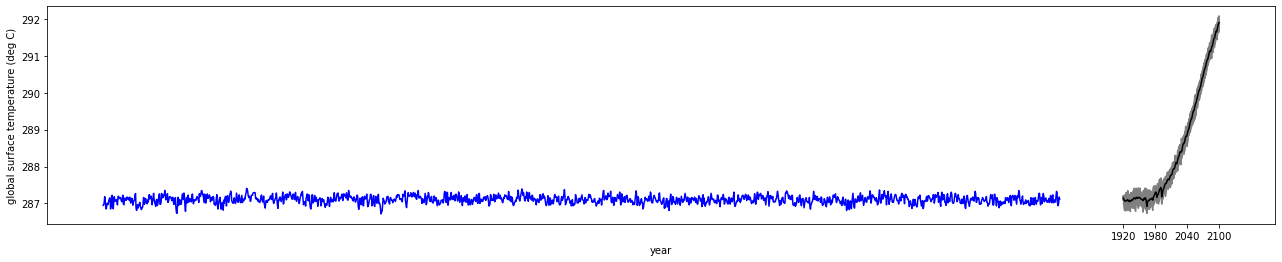

In [4]:
## It's always a good idea to plot your data before you start doing any calculations.  "Look at your data"!
## Let's make a quick line plot of global annual mean temperature timeseries 
## from the 1850 control and the ensemble members.
## Not the prettiest plot... e.g., font is WAY TO SMALL ... but it works to "look at our data :)"
plt.rcParams["figure.figsize"] = [22,4]
[plt.plot(year,gts.sel(member=i),color="grey") for i in range(1,31)] ## plot all ensemble members
plt.plot(year,gts.mean("member"),color="black")  ## plot ensemble mean
plt.xlabel('year')
plt.ylabel('global surface temperature (deg C)')
plt.xticks(np.arange(1920,2101,60),["1920","1980","2040","2100"])

plt.plot(gts_1850,color="blue");  ## add ";" to not print to screen plotting comments

### LEARNING GOAL #2 - Assess global warming and compare it to the pre-industrial climate

First - Use the 2600-year long 1850 control run to calculate population statistics with constant forcing (in the absence of climate change). Find the population mean and population standard deviation for CESM1 global annual mean surface temperature. Standardize the data and again find the population mean and population standard deviation.  Plot a histogram of the standardized data. Is the distribution Gaussian?

In [5]:
#### With the 1850 control we have the opportunity to calculate close to population statistics with constant forcing.
#### Let's find the population mean and population standard deviation from the 1850 control.  
gts_1850_mean=np.mean(gts_1850)
gts_1850_std=np.std(gts_1850)
print(f'Mean 1850 global mean surface temperature: {np.round(gts_1850_mean.values)}')
print(f'Standard deviation in 1850 global mean surface temperature: {np.round(gts_1850_std.values,1)}')

Mean 1850 global mean surface temperature: 287.0
Standard deviation in 1850 global mean surface temperature: 0.1


Standardized 1850 global mean surface temperature:
mean: 0.0
std: 1.0


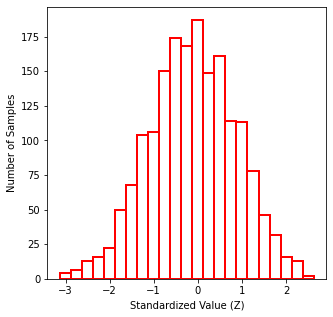

In [6]:
#### Standardize the data and plot a histogram
gts_1850_norm=(gts_1850-gts_1850_mean)/gts_1850_std
gts_1850_norm_mean=np.mean(gts_1850_norm).values
gts_1850_norm_std=np.std(gts_1850_norm).values
print("Standardized 1850 global mean surface temperature:")
print(f'mean: {np.round(gts_1850_norm_mean,2)}')
print(f'std: {np.round(gts_1850_norm_std,2)}')

xinc = np.arange(-3,3,.25)
hx=np.histogram(gts_1850_norm,xinc)
plt.rcParams["figure.figsize"] = [5,5]
plt.bar(hx[1][:-1],hx[0],edgecolor = 'r', color = [], width = .25, linewidth = 2);
plt.ylabel('Number of Samples');
plt.xlabel('Standardized Value (Z)');

## another histogram option to try (might be deprecated)
#xinc = np.arange(-3,3,.25);
#plt.hist(gts_1850_norm,xinc);
#plt.ylabel('Number of Samples');
#plt.xlabel('Standardized Value (Z)');

Next, calculate global warming in the first ensemble member over a given time period defined by the startyear and endyear variables.  Compare the warming in this first ensemble member with the 1850 control run statistics and assess if the warming is statistically significant. Use hypothesis testing and state the 5 steps.  What is your null hypothesis?  Try using a z-statistic (appropriate for N>30) and a t-statistic (appropriate for N<30). What is the probability that the warming in the first ensemble member occurred by chance? Change the startyear and endyear variables – When does global warming become statistically significant in the first ensemble member?  

nyears: 30
<xarray.DataArray 'gts_ann_allcesmle' (year: 30)>
array([288.1468 , 288.18713, 288.27487, 288.22516, 288.33203, 288.28644,
       288.09985, 288.30484, 288.40485, 288.3772 , 288.3201 , 288.3768 ,
       288.53033, 288.60718, 288.54056, 288.57913, 288.66653, 288.71402,
       288.96912, 288.93573, 288.7043 , 288.69955, 288.96347, 289.06717,
       289.1458 , 289.11206, 289.1201 , 289.25125, 289.25885, 289.25046],
      dtype=float32)
Coordinates:
    member   int32 1
  * year     (year) int32 2020 2021 2022 2023 2024 ... 2045 2046 2047 2048 2049
Attributes:
    NCL:             month_to_annual
    cell_methods:    time: mean
    long_name:       Surface temperature (radiative)
    units:           K
    average_op_ncl:  dim_avg over dimension(s): lon
Standardized mean CESM LE member 1: 14.89


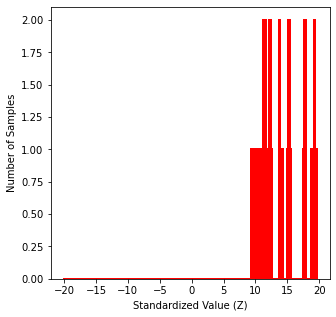

In [15]:
### Next let's calculate the global warming in the first ensemble member over a given time period.
### Our end goal is compare this warming to the 1850 control run and assess if the warming is statistically significant.

### Start by standardizing member 1 data using the 1850 control mean and standard deviation
startyear=2020 ##CHANGE ME
endyear=2050   ##CHANGE ME
nyrs=(endyear-startyear)
print(f'nyears: {nyrs}')
gts_mem1=gts.sel(member=1).sel(year=slice(startyear,endyear-1))
print(gts_mem1)
gts_mem1_norm=(gts_mem1-gts_1850_mean)/gts_1850_std

print(f'Standardized mean CESM LE member 1: {np.round(np.mean(gts_mem1_norm).values,2)}')

## plot a histogram to see the range of values
xinc = np.arange(-20,20,.25)
hx=np.histogram(gts_mem1_norm,xinc);
plt.bar(hx[1][:-1],hx[0],edgecolor = 'r', color = 'k', width = .25, linewidth = 2);
plt.ylabel('Number of Samples');
plt.xlabel('Standardized Value (Z)');

In [16]:
## What is the probability that the mean annual global mean temperature was X assuming no global warming?
## Test the null hypothesis that the sample mean is equal to the population mean.
## Assume that the Global Mean Annual Temperature is standard normal. 

## Using Barnes equation (83) to calculate probability using z-statistic
sample_mean=np.mean(gts_mem1_norm).values
print(f'sample_mean: {np.round(sample_mean,2)}')
population_mean=gts_1850_norm_mean
population_std=gts_1850_norm_std
xstd=population_std/np.sqrt(nyrs)
z=(sample_mean-population_mean)/xstd
print("Z-statistic:")
print(np.round(z,2))
print("Probability (percent):")
prob=(1-stats.norm.cdf(z))*100
print(np.round(prob,2))

## Using Barnes equation (96) to calculate probability using the t-statistic
sample_mean=np.mean(gts_mem1_norm).values
sample_std=np.std(gts_mem1_norm).values
print("T-statistic:")
t=(sample_mean-population_mean)/(sample_std/(np.sqrt(nyrs-1)))
print(np.round(t,2))
print("Probability (percent):")
prob=(1-stats.t.cdf(t,nyrs-1))*100
print(np.round(prob,2))

print('Try using a ttest function from python')
#stats.ttest_ind(gts_1850_norm,gts_mem1_norm)

tw=stats.ttest_ind(gts_mem1_norm,gts_1850_norm,equal_var = False) 
#Note: When equal_var is false (defaults to true), you assume the underlying population variances are NOT equal 
## and this function then uses Welch's T-test
print(stats.ttest_ind(gts_mem1_norm,gts_1850_norm,equal_var = False)) 

if tw.statistic>tw.pvalue:
    print('Can reject the null hypthesis.')
else:
    print('Cannot reject the null hypthesis.')    

sample_mean: 14.89
Z-statistic:
81.58
Probability (percent):
0.0
T-statistic:
22.66
Probability (percent):
0.0
Try using a ttest function from python
Ttest_indResult(statistic=22.649031512492353, pvalue=5.099849121669486e-20)
Can reject the null hypthesis.


### LEARNING GOAL #3 - Calculate confidence intervals on the global warming using z-statistic and t-statistic


In [9]:
### Use the code below to calculate how much global warming occurred over the 21st century in both 
### individual ensemble members and the ensemble mean.

## Compare 21st century global warming: one member vs. ensemble mean
gw_mem1=gts.sel(member=1).sel(year=slice(2080,2100)).mean("year")- \
        gts.sel(member=1).sel(year=slice(2000,2020)).mean("year")
gw_mean=(gts.sel(year=slice(2080,2100)).mean("year").mean("member"))- \
        (gts.sel(year=slice(2000,2020)).mean("year").mean("member"))
print(f'21st century global warming - member 1: {gw_mem1.values}')
print(f'21st century global warming - mean: {gw_mean.values}')

21st century global warming - member 1: 3.695220947265625
21st century global warming - mean: 3.633331298828125


In [10]:
## Next - let's calculate emsemble statistics about 21st century global warming
nmembers=30
temp=(gts.sel(member=slice(1,nmembers)).sel(year=slice(2080,2100)).mean("year")-\
      gts.sel(member=slice(1,nmembers)).sel(year=slice(2000,2020)).mean("year"))
gw_mean_mem=temp.mean("member")
gw_std_mem=temp.std("member")
gw_min_mem=temp.min("member")
gw_max_mem=temp.max("member")
print('21st century global warming statistics:')
print(f'mean: {gw_mean_mem.values}')
print(f'stdev: {gw_std_mem.values}')
print(f'min: {gw_min_mem.values}')
print(f'max: {gw_max_mem.values}')

21st century global warming statistics:
mean: 3.6333627700805664
stdev: 0.06271209567785263
min: 3.5054931640625
max: 3.754974365234375


In [11]:
### Let's add confidence intervals to the estimated global warming
### Specifically - we'll compare confidence intervals calculated using t-statistic and z-statistic

#### Calculate the 95% and 99% confidence limits on the 21st century warming using t-statistic
#### Assume that the global warming is normally distributed.
N=nmembers
df=N-1

## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
tstat95=stats.t.ppf(0.975,df)
low_limit95=gw_mean_mem-tstat95*(gw_std_mem/np.sqrt(nmembers-1))
high_limit95=gw_mean_mem+tstat95*(gw_std_mem/np.sqrt(nmembers-1))
print(f'95% confidence limits - t-statistic: {np.round(low_limit95.values,2)} < X < {np.round(high_limit95.values,2)}')

## Note: Python calculates left/lower-tail probabilities by default, so for the 99% confidence interval, use 0.995
tstat99=stats.t.ppf(0.995,df)
low_limit99=gw_mean_mem-tstat99*(gw_std_mem/np.sqrt(nmembers-1))
high_limit99=gw_mean_mem+tstat99*(gw_std_mem/np.sqrt(nmembers-1))
print(f'99% confidence limits - t-statistic: {np.round(low_limit99.values,2)} < X < {np.round(high_limit99.values,2)}')

#### Calculate the 95% and 99% confidence limits on the 21st century warming using z-statistic
#### Assume that the global warming is normally distributed.

## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
zstat95=stats.norm.ppf(0.975)
low_limit95=gw_mean_mem-zstat95*(gw_std_mem/np.sqrt(nmembers))
high_limit95=gw_mean_mem+zstat95*(gw_std_mem/np.sqrt(nmembers))
print(f'95% confidence limits - z-statistic: {np.round(low_limit95.values,2)} < X < {np.round(high_limit95.values,2)}')

## Note: Python calculates left/lower-tail probabilities by default, so for the 99% confidence interval, use 0.995
zstat99=stats.norm.ppf(0.995)
low_limit99=gw_mean_mem-zstat99*(gw_std_mem/np.sqrt(nmembers))
high_limit99=gw_mean_mem+zstat99*(gw_std_mem/np.sqrt(nmembers))
print(f'99% confidence limits - z-statistic: {np.round(low_limit99.values,2)} < X < {np.round(high_limit99.values,2)}')

95% confidence limits - t-statistic: 3.61 < X < 3.66
99% confidence limits - t-statistic: 3.6 < X < 3.67
95% confidence limits - z-statistic: 3.61 < X < 3.66
99% confidence limits - z-statistic: 3.6 < X < 3.66


[3.695221  3.636963  3.652832  3.6441956 3.634613  3.5675354 3.6606445
 3.7267761 3.5054932 3.6834412 3.5503845 3.5212708 3.5517578 3.6859741
 3.619995  3.7277527 3.6286316 3.541504  3.5733337 3.5706787 3.6762085
 3.6142273 3.6184998 3.6961365 3.6150513 3.6669922 3.6224976 3.688324
 3.7549744 3.6689758]
[3.5  3.55 3.6  3.65 3.7  3.75]


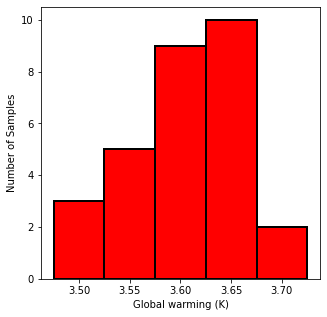

In [12]:
#### plot a histogram of global warming - Was normal distribution a good approximation?
gw_allmem=gts.sel(member=slice(1,nmembers)).sel(year=slice(2080,2100)).mean("year")- \
        gts.sel(member=slice(1,nmembers)).sel(year=slice(2000,2020)).mean("year")
print(gw_allmem.values)

## plot a histogram to see the range of values
xinc = np.arange(3.5,3.8,.05)
print(xinc)
hx=np.histogram(gw_allmem,xinc)
plt.bar(hx[1][:-1],hx[0],edgecolor = 'k', color = 'r', width = .05, linewidth = 2);
plt.ylabel('Number of Samples');
plt.xlabel('Global warming (K)');

### another histogram option
#xinc = np.arange(3.5,3.8,.05)
#plt.hist(gw_allmem,xinc);
#plt.ylabel('Number of Samples');
#plt.xlabel('Global warming (K)');

Many climate modeling centers run only a handful of ensemble members for climate change projections. Given that the CESM Large Ensemble has lots of members, you can calculate the warming over the 21st century and place confidence intervals in that warming by assessing the spread across ensemble members.  Calculate confidence intervals using both a z-statistic and a t-statistic.  How different are they?  Plot a histogram of global warming in the ensemble members – Is a normal distribution a good approximation? Re-do your confidence interval analysis by assuming that you only had 6 ensemble members or 3 ensemble members.  How many members do you need?  Look at the difference between a 95% confidence interval and a 99% confidence interval.

In [13]:
#### What if you you only had 6 ensemble members?  Estimate your confidence interval using a t-statistic.
## Calculate statistics for the 21st century global warming
nmembers=6
temp=(gts.sel(member=slice(1,nmembers)).sel(year=slice(2080,2100)).mean("year")-\
      gts.sel(member=slice(1,nmembers)).sel(year=slice(2000,2020)).mean("year"))
print(temp)
gw_mean_mem=temp.mean("member")
gw_std_mem=temp.std("member")
gw_min_mem=temp.min("member")
gw_max_mem=temp.max("member")

print('21st century global warming statistics:')
print(f'mean: {gw_mean_mem.values}')
print(f'stdev: {gw_std_mem.values}')
print(f'min: {gw_min_mem.values}')
print(f'max: {gw_max_mem.values}')

<xarray.DataArray 'gts_ann_allcesmle' (member: 6)>
array([3.695221 , 3.636963 , 3.652832 , 3.6441956, 3.634613 , 3.5675354],
      dtype=float32)
Coordinates:
  * member   (member) int32 1 2 3 4 5 6
21st century global warming statistics:
mean: 3.6385600566864014
stdev: 0.03765752911567688
min: 3.567535400390625
max: 3.695220947265625


In [17]:
#### Calculate the 95% and 99% confidence limits on the 21st century warming using t-statistic
#### Assume that the global warming is normally distributed.  (See page 18 of Barnes notes)
N=nmembers
df=N-1

## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
tstat95=stats.t.ppf(0.975,df)
low_limit95=gw_mean_mem-tstat95*(gw_std_mem/np.sqrt(nmembers-1))
high_limit95=gw_mean_mem+tstat95*(gw_std_mem/np.sqrt(nmembers-1))
print(f'95% confidence limits - t-statistic: {np.round(low_limit95.values,2)} < X < {np.round(high_limit95.values,2)}')

## Note: Python calculates left/lower-tail probabilities by default, so for the 99% confidence interval, use 0.995
tstat99=stats.t.ppf(0.995,df)  #### FIXED - this said stats.norm.ppf instead of stats.t.ppf
low_limit99=gw_mean_mem-tstat99*(gw_std_mem/np.sqrt(nmembers-1))
high_limit99=gw_mean_mem+tstat99*(gw_std_mem/np.sqrt(nmembers-1))
print(f'99% confidence limits - t-statistic: {np.round(low_limit99.values,2)} < X < {np.round(high_limit99.values,2)}')

95% confidence limits - t-statistic: 3.6 < X < 3.68
99% confidence limits - t-statistic: 3.57 < X < 3.71


### SOLVED MYSTERY - Rounding works within f'' statements!

### SUMMARIZE WHAT YOU FOUND AND WHAT YOU LEARNED...  

When is global warming statistically significant?  What are the statistical tests you used?  How important is the ensemble size?

 - For t-statistics with confidence intervals you need to divide the part outsdide the confidence interval by 2 and add that back to the confidence interval level (i.e. 95% becomes 97.5%)
 - How to calculate z and t statistics using python
 - Standardizing distributions (mean of 0, standard deviation of 1) 